In [15]:
import os
import numpy as np 
from numpy import cos, sin
import matplotlib.pyplot as plt
import multiprocessing
import time
# import visualisation

%matplotlib inline

import seaborn as sns
sns.set()

## Progress bar
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as td
import torch.optim as optim
torch.backends.cudnn.benchmark = True 

import torchvision as tv


print("Using torch", torch.__version__)

Using torch 1.10.0+cu111


In [16]:
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():  # GPU operation have separate seed
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)


set_seed(42)

In [17]:
# Fetching the device that will be used throughout this notebook
device = torch.device("cpu") if not torch.cuda.is_available() else torch.device("cuda:0")
print("Using device", device)

from google.colab import drive
drive.mount('/content/drive')

DATASET_PATH = "drive/MyDrive/Liverpool/Assignments/Year 3/COMP341/COMP341 - Assignment 01 - Data/Data/"

Using device cuda:0
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [18]:
from torch.utils.data import Dataset
from PIL import Image

class GraspDataset(Dataset):
  def __init__(self, root_dir, transforms=None, depth_image=None):
      self.root_dir = root_dir
      self.depth_image = {'perfect':'pDepth', 'stereo': 'sDepth'}.get(depth_image)
      self.transforms = transforms

      # List of all scenes for all objects in the dataset
      self.scene_paths = []
      for object_name in os.listdir(root_dir):
        for scene_index in range(5): # Scene index ranges from 0 to 4 for all objects

          scene_root = f"{root_dir}/{object_name}/{scene_index}_{object_name}_"

          # Make sure a scene with this index exists for this object
          grasp_path = scene_root + "grasps.txt"
          if not os.path.exists(grasp_path): continue

          # Add scene files and appened to the list
          scene = {
              "grasps": grasp_path,
              "rgb": scene_root + "RGB.png",
              "mask": scene_root + "mask.png",
              "pDepth": scene_root + "perfect_depth.tiff",
              "sDepth": scene_root + "stereo_depth.tiff"
          }
          self.scene_paths.append(scene)

  # This must return the length of the dataset
  def __len__(self):
    return len(self.scene_paths)

  # This must return the single dataset item at index idx
  def __getitem__(self, idx):

    # Load the grasps
    grasps = []
    with open(self.scene_paths[idx]["grasps"]) as file:
      lines = file.readlines()
      for line in lines:
        x, y, theta, openning, jaw_size = [float(number) for number in line.split(";")]
        grasp = [x, y, theta, openning, jaw_size]
        grasps.append(grasp)
    grasps = np.array(grasps, dtype=np.float32)

    # Load the RGB image
    image = Image.open(self.scene_paths[idx]["rgb"])

    if self.transforms: #do transforms
        image = self.transforms(image)

    if self.depth_image is not None:
      depth = Image.open(self.scene_paths[idx][self.depth_image])
      return (image, depth, grasps[0])

    return (image, grasps[0])

In [19]:
# functions to show an image
def imshow(img):
    """
    :param img: (PyTorch Tensor)
    """
    # unnormalize
    img = img / 2 + 0.5     
    # Convert tensor to numpy array
    npimg = img.numpy()
    # Color channel first -> color channel last
    npimg = np.transpose(npimg, (1, 2, 0))
    
    plt.imshow(npimg)

grasp: tensor([512.5854, 494.2139, -64.5562, 163.5000,  25.6021])
depth: tensor([[1.5743, 1.5743, 1.5743,  ..., 1.5743, 1.5743, 1.5743],
        [1.5741, 1.5741, 1.5741,  ..., 1.5741, 1.5741, 1.5741],
        [1.5739, 1.5739, 1.5739,  ..., 1.5739, 1.5739, 1.5739],
        ...,
        [1.4326, 1.4326, 1.4326,  ..., 1.4326, 1.4326, 1.4326],
        [1.4324, 1.4324, 1.4324,  ..., 1.4324, 1.4324, 1.4324],
        [1.4324, 1.4324, 1.4324,  ..., 1.4324, 1.4324, 1.4324]])


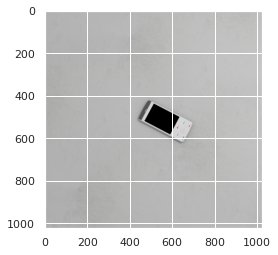

In [20]:
# Show off the dataset
index = 3
dataset = GraspDataset(DATASET_PATH + "/training", depth_image="perfect")
loader = td.DataLoader(dataset, batch_size=4, shuffle=False, drop_last=False, num_workers=2)

batch = next(iter(loader))

print("grasp:", batch[2][index])
print("depth:", batch[1][index])
imshow(batch[0][index])

In [32]:
class DeepConvNN(nn.Module):
    def __init__(self):
        super(DeepConvNN, self).__init__()

        # Input image is size 1024x1024
        self.conv1 = nn.Conv2d(3, 64, kernel_size=6, stride=2, padding=0) # output is 510x510
        #torch.nn.init.xavier_uniform_(self.conv1.weight)
        self.batchN = nn.BatchNorm2d(64)
        
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0) # output is 255x255
        
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=0) # output is 127x127
        #torch.nn.init.xavier_uniform_(self.conv2.weight)
        self.batchN2 = nn.BatchNorm2d(128)
        
        self.pool2 = nn.MaxPool2d(kernel_size=3, stride=2, padding=0) # output is 63x63
        
        self.fc1 = nn.Linear(508032, 5)

    def forward(self, x):

        x = self.conv1(x)
        x = self.batchN(x)
        x = F.relu(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.batchN2(x)
        x = F.relu(x)
        x = self.pool2(x)

        # flatten tensor
        x = x.view(x.size()[0], -1)

        x = self.fc1(x)

        return x

In [22]:
def get_cnn_output_size(in_size, kernel_size, stride=1, padding=0):
    integer = int((in_size - kernel_size + 2 * padding) / stride) == ((in_size - kernel_size + 2 * padding) / stride)
    if not integer:
        print("not int", ((in_size - kernel_size + 2 * padding) / stride))
    return int((in_size - kernel_size + 2 * padding) / stride) + 1

In [23]:
get_cnn_output_size(252, kernel_size=3, stride=1, padding=0)

250

In [24]:
def getLoss():
    return nn.MSELoss()

def getOptimiser(model, learningRate):
    #optimiser = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
    optimiser = optim.Adam(model.parameters(), lr=learningRate)
    return optimiser

In [25]:
def gen_transforms(resize=None, imgs_mean=(0.5,), imgs_std=(0.5,)):
    tst_trans = [tv.transforms.ToTensor()]
    if resize is not None:
        tst_trans.append(tv.transforms.Resize(resize[0]))
        tst_trans.append(tv.transforms.CenterCrop(resize[1]))
    tst_trans.append(tv.transforms.Normalize(mean=imgs_mean, std=imgs_std))
    return tv.transforms.Compose(tst_trans)

def get_train_loader(batchSize, resize=None):
    transforms = gen_transforms(resize)
    trainData = GraspDataset(root_dir=f'{DATASET_PATH}/training', transforms=transforms)
    trainLoader = td.DataLoader(trainData, batch_size=batchSize, shuffle=True, drop_last=False, num_workers=2)
    return trainLoader

In [26]:
# trainLoader = get_train_loader(4)
# batch = next(iter(trainLoader))
# batch[0].shape

In [27]:
def train(model, batch_size, n_epochs, learning_rate, resize=None):
    print(f"batch size: {batch_size}")
    print(f"n epochs: {n_epochs}")
    print(f"learning rate: {learning_rate}")
    print("="*20)
    
    trainLoader = get_train_loader(batch_size, resize)
    lossFn = getLoss()
    optimizer = getOptimiser(model, learning_rate)

    train_history = []
    accuracy_history = []
    training_start_time = time.time()
    
    model = model.to(device) # Move model to gpu
    model.train() # Set the model to training mode (for DropOut)

    for epoch in range(n_epochs):  # loop over the dataset for n_epoch
        epoch_loss = 0
        epoch_accuracy = 0
        
        with tqdm(trainLoader, unit="batch") as tepoch:
            for rgb, grasp in tepoch:   #for each batch
                tepoch.set_description(f"Epoch {epoch}")
                # Move tensors to gpu
                rgb, grasp = rgb.to(device), grasp.to(device)
               
                # zero the parameter gradients
                optimizer.zero_grad()

                # forward + backward + optimize
                outputs = model(rgb)
                # _, predicted = outputs.argmax(dim=1, keepdim=True).squeeze()
                #  = torch.max(outputs, 1)
                # print('out', outputs.size(), 'targets', grasps.size())
                # g = torch.FloatTensor(grasp.cpu().numpy()).to(device)
                loss = lossFn(outputs,  grasp)
                loss.backward()
                optimizer.step()
                # add to running totals
                epoch_loss += loss.item()
                with torch.no_grad():
                    accs = grasp_accuracy(outputs.cpu().numpy(), grasp.cpu().numpy())
                    epoch_accuracy += accs
        epoch_loss = epoch_loss / len(trainLoader)
        # print(f"Epoch #{epoch + 1} train_loss: {round(epoch_loss,2)} accuracy: {round(epoch_accuracy,1)}% took: {round(time.time() - start_time,2)}s") 
        train_history.append(epoch_loss)
        accuracy_history.append(epoch_accuracy/len(trainLoader))
        
    print(f"Training Finished, took {round(time.time() - training_start_time,1)}s")
    return train_history, accuracy_history

In [33]:
BATCH_SIZE = 4
EPOCHS = 10
LEARNING_RATE = 0.001

nnet = DeepConvNN()

train_loss = train(nnet, BATCH_SIZE, EPOCHS, LEARNING_RATE)

batch size: 4
n epochs: 10
learning rate: 0.001


  0%|          | 0/8 [00:00<?, ?batch/s]

  0%|          | 0/8 [00:00<?, ?batch/s]

  0%|          | 0/8 [00:00<?, ?batch/s]

  0%|          | 0/8 [00:00<?, ?batch/s]

  0%|          | 0/8 [00:00<?, ?batch/s]

  0%|          | 0/8 [00:00<?, ?batch/s]

  0%|          | 0/8 [00:00<?, ?batch/s]

  0%|          | 0/8 [00:00<?, ?batch/s]

  0%|          | 0/8 [00:00<?, ?batch/s]

  0%|          | 0/8 [00:00<?, ?batch/s]

Training Finished, took 37.6s


In [29]:
colors = [[31, 120, 180], [51, 160, 44]]
colors = [(r / 255, g / 255, b / 255) for (r, g, b) in colors]

def plot_epochs(train_history, val_history, plotType="loss"):
    x = np.arange(1, len(train_history) + 1)
    plt.figure(figsize=(8, 6))
    plt.plot(x, val_history, color=colors[1], label=f"Validation {plotType}", linewidth=2)
    plt.plot(x, train_history, color=colors[0], label=f"Training {plotType}", linewidth=2)
    plt.ylabel(f'{plotType}')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')
    plt.title(f"Evolution of the training and validation {plotType}")
    plt.show()

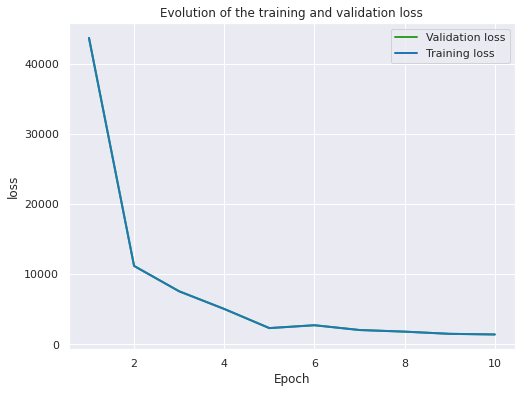

In [34]:
plot_epochs(train_loss, train_loss)